# **Supercenter**

## **Business Case:**
SuperCenter, a supermarket chain, has experienced significant growth by focusing on natural and organic foods. Despite good financial performance, there are increasing concerns about poor customer experience and ineffective product diversity awareness among customers. The chain is now prioritizing technological advancements and data-driven strategies to enhance customer engagement and operational efficiency.

## **Goals:**
- Implement data analytics and customer insight to understand customer preferences better and improve the shopping experience.

- Optimize Product Strategy: Implement recommendations systems for complementary and similar products, tailored to individual customer profiles. This should also contribute to reducing stock levels by efficiently managing product bundles or offers.
- Leverage the Google Cloud Platform for enhancing data governance and analytics capabilities.
- Formulate a technology transformation roadmap to oversee investment in advanced analytics and AI


# **0. Importing Libraries and Setup**

As the code will be run in **Google Cloud Platform (GCP)** we will need to setup the environment.

- Authenticate our **credentials**.
- **Install neccessary libraries** not by default in GCP.
- Define the **PROJECT_ID** and **LOCATION** where the cluster will run.



In [ ]:
#installing libraries not in GCP
!pip install google-cloud-aiplatform scann --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 14.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [ ]:
# colab auth
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Define the PROJECT_ID and LOCATION in GCP.
PROJECT_ID = "capstoneie"  #ADD PROJECT_ID:
LOCATION = "us-central1"  # Choose location.

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Part,
)

import time

import pandas as pd
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)



# **1.Loading & pre-processing the datasets**

We'll be using the following datasets provided by the customer **Supercenter**:

- `tabla_producto.xlsx` : dataset containing unique product id, product name and foreign keys to relate the product to it's corresponding department and pasillo (aisle).

- `tabla_departamento.xlsx`: dataset containing information on the different product categories.

- `tabla_pasillos,xlsx`: dataset containing information on the different aisles where the products can be found in the physical store.


After loading all three datasets, we'll merge them to have all available information in one dataframe.


As a **proof of concept**, our solution will be executed in a **reduced sample of products**.

The sampled products (**100 items**) will belong to the aisle **NECTARES DE JUGO (juices)** inside the category **BEBIDAS(beverages)**.






In [ ]:
# Loading the product dataset
#the file has been uploaded manually to GCP, in production it could be loaded from a BigQuery table
df_producto = pd.read_excel('/content/tabla_producto.xlsx')

In [ ]:
#Loading department and pasillo tables
#the file have been uploaded manually to GCP, in production they could be loaded from BigQuery tables

df_department = pd.read_excel('/content/tabla_departamento.xlsx')

df_pasillo = pd.read_excel('/content/tabla_pasillos.xlsx')


**Merging all datasets:**

We use a **left join** instead of an **inner join** as there are products without a matching departmento/pasillo. (We observed this in the EDA notebook)


In essence if all products have a matching departamento/pasillo, the left join will return the same results as an inner join.

In [ ]:
# merging product table with department table and pasillo table
#note: we use a 'left join' as opposed to an 'inner join' as there are products without a matching departmento/pasillo..(we observed this in the EDA notebook)
# In essence if all products have a matching departamento/pasillo, the left join will return the same results as an inner join.
df_producto_merged = df_producto.merge(df_department, how='left', on='id_departamento'). \
                merge(df_pasillo, how='left', on='id_pasillo')

#dropping columns that reference the keys
df_producto_merged = df_producto_merged.drop(columns=['id_pasillo', 'id_departamento'], axis=1)

In [ ]:
#Printing first rows of the merged dataframe
df_producto_merged.head()

,id_producto,nombre_producto,departamento,pasillo
0,1,GALLETAS DEL EMPAREDADO DEL CHOCOLATE,MERIENDAS,GALLETAS PASTELES
1,2,TODAS ESTACIONES DE SALT,DESPENSA,ESPECIAS CONDIMENTOS
2,3,ROBUSTA DE ORO SIN AZÚCAR TÉ OOLONG,BEBIDAS,TÉ
3,4,SALSA INTELIGENTES ONES FAVORITOS MINI CLÁSICO RIGATONI CON VODKA CREAM,CONGELADOS,COMIDA CONGELADA
4,5,EN CUALQUIER MOMENTO SALSA VERDE CHILE,DESPENSA,PREPARACIÓN DE LA CARNE MARINADOS


For our proof of concept, we'll select only **100 items** from the department **BEBIDAS** and aisle **NÉCTARES DE JUGO**.

Sampling all products which are from the same department and aisle will help us demostrate the solution in an optimal way.




In [ ]:

#filtering on pasillo NÉCTARES DE JUGO and subsetting to only 100 products.
juices_100items = df_producto_merged[(df_producto_merged['departamento'] == 'BEBIDAS') & (df_producto_merged['pasillo'] == 'NÉCTARES DE JUGO')][:100]

juices_100items

,id_producto,nombre_producto,departamento,pasillo
6,7,PURA AGUA DE COCO CON NARANJA,BEBIDAS,NÉCTARES DE JUGO
19,20,GRANADA ARÁNDANO Y ALOE VERA ENRICH BEBIDA,BEBIDAS,NÉCTARES DE JUGO
52,53,JUGO DE ALOE PURO TODA HOJA CON LIMÓN,BEBIDAS,NÉCTARES DE JUGO
81,82,NATURAL 100% JUGO DE MANZANA,BEBIDAS,NÉCTARES DE JUGO
192,193,FRUITWATER® FRESA KIWI AGUA CON GAS,BEBIDAS,NÉCTARES DE JUGO
...,...,...,...,...
5846,5883,LIMONADA DE FRESA ORGÁNICA,BEBIDAS,NÉCTARES DE JUGO
5882,5919,"JUGO, PIÑA COCO",BEBIDAS,NÉCTARES DE JUGO
5898,5935,COCKTAIL MIXER NARANJA DE SANGRE,BEBIDAS,NÉCTARES DE JUGO
5960,5997,ARÁNDANO CON JUGO DE CALCIO CÓCTEL,BEBIDAS,NÉCTARES DE JUGO


In [ ]:
#Printing the number of rows of the filtered dataframe
len(juices_100items)

100

#**2. Solution #1:** Search Engine Optimization

### **Business Problem:**
SuperCenter's online store currently relies on a traditional keyword-based search engine, which often fails to understand customers' natural language queries accurately. This results in suboptimal search results, leading to frustration and dissatisfaction among customers, ultimately impacting their overall shopping experience and engagement with the online store.


### **Use Case:** Improve Customer Experience and Engagement

Implement an embedding-based search engine that understands natural language queries, allowing customers to search for products using conversational language rather than relying on specific keywords.

Enhance the online shopping experience for customers across all product catalog by improving search accuracy and relevance.

Increased customer satisfaction scores, higher conversion rates, and longer session times on the website, indicating a better user experience. Measure the impact through metrics like customer satisfaction surveys, bounce rates, CTR (click-through-rate) and number of  items per shopping cart.



The solution aims to **enhance the search experience on SuperCenter's online store by leveraging advanced natural language processing (NLP) and embeddings technology.**

Here's how it works:

1. **Product Description Optimization**: To ensure accurate and relevant search results, we first optimize the product descriptions using Google's generative AI model, Gemini.
2. **Embeddings Generation**: Next, we convert the product names and the optimized product descriptions into numerical representations called embeddings. These embeddings capture the semantic meaning and context of the text, enabling us to compare and match them with customer queries more effectively. We use Google's pre-trained text embedding models, which have been trained on vast amounts of data, to generate these embeddings.
3. **Similarity Computation**: To ensure the accuracy of the generated product descriptions, we compute the similarity between the embeddings of the product name and the corresponding description. This step helps identify and correct any potential discrepancies between the product name and the generated description, ensuring that the search results are highly relevant.
4. **Search Engine Implementation**: The core of the solution is the embedding-based search engine, built using the SCANN (Scalable Clustered and Approximate Nearest Neighbors) library. When a customer enters a query on SuperCenter's website, we convert that query into an embedding using the same pre-trained models. The search engine then compares this query embedding with the embeddings of all the product descriptions and retrieves a ranked list of the most relevant products based on their similarity scores.

## **2.1 Product Description Optimization**


### 2.1.1 Loading the model

In [ ]:
#choosing one of Google's pre-trained Large Language Model
MODEL_ID = "gemini-1.0-pro"

model = GenerativeModel(MODEL_ID)

### 2.1.2 Testing the model

Before we run the model to generative optimized descriptions for the whole dataframe we'll test it to make sure the results are as expected.

Below code will connect to **Gemini's API** and pass it a prompt to create a product description based on an example product name.

The response will contain the following:

- Generated text (product description).
- Number of Tokens used so we can calcuate cost per description.
- Safety scores for different categories so we can monitor the generated content.    
- Confirmation that the request has been succesful.

In [ ]:
# Load a example model with system instructions
example_model = GenerativeModel(
    MODEL_ID,
    system_instruction=[
        "You are a helpful SEO copywriter.",
        "Your task is to write product descriptions in Spanish based on the product name.",
        "The description should be max 200 characters long.",
    ],
)

# Set model parameters
generation_config = GenerationConfig(
    temperature=0.9,
    top_p=1.0,
    top_k=32,
    candidate_count=1,
    max_output_tokens=500,
)

# Set safety settings
safety_settings = {
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
}


prompt = """
  Product name: Bananas organicas de Ecuador.
"""

# Set contents to send to the model
contents = [prompt]

# Counts tokens
print(example_model.count_tokens(contents))

# Prompt the model to generate content
response = example_model.generate_content(
    contents,
    generation_config=generation_config,
    safety_settings=safety_settings,
)

# Print the model response
print(f"\nAnswer:\n{response.text}")
print(f'\nUsage metadata:\n{response.to_dict().get("usage_metadata")}')
print(f"\nFinish reason:\n{response.candidates[0].finish_reason}")
print(f"\nSafety settings:\n{response.candidates[0].safety_ratings}")

total_tokens: 12
total_billable_characters: 38


Answer:
##  Deliciosas bananas orgánicas ecuatorianas, cultivadas con amor para una experiencia naturalmente dulce y nutritiva. 100% libres de químicos. 🍌 🇪🇨 


Usage metadata:
{'prompt_token_count': 47, 'candidates_token_count': 40, 'total_token_count': 87}

Finish reason:
1

Safety settings:
[category: HARM_CATEGORY_HATE_SPEECH
probability: NEGLIGIBLE
probability_score: 0.11201595515012741
severity: HARM_SEVERITY_NEGLIGIBLE
severity_score: 0.09929540008306503
, category: HARM_CATEGORY_DANGEROUS_CONTENT
probability: NEGLIGIBLE
probability_score: 0.17981843650341034
severity: HARM_SEVERITY_NEGLIGIBLE
severity_score: 0.09518112242221832
, category: HARM_CATEGORY_HARASSMENT
probability: NEGLIGIBLE
probability_score: 0.09138210862874985
severity: HARM_SEVERITY_NEGLIGIBLE
severity_score: 0.07935289293527603
, category: HARM_CATEGORY_SEXUALLY_EXPLICIT
probability: LOW
probability_score: 0.5634379982948303
severity: HARM_SEVERITY_LOW
severity_

### 2.1.2 Defining a function
We'll define a function that loops over the dataframe and applies the GenAI model to every row.

The function will use a prompt with instructions on how the descriptions should be generated. The given prompt includes the product's name, category and aisle so that it more accurately can identify a product and create an optimal description.



The **function returns a dataframe** including the **generated description as well as the metadata of the request** (safety metrics, tokens used and finish reason).


**NOTE:** We added `time.sleep(15)` to the loop as there is a max number of request per minute. Limit is 300 RPM for Businesses and 5 RPM for private individuals.
  - The 100 descriptions were generated in 27 minutes using `time.sleep(15)`.
  - For the complete dataset (49k items) and having access to a business account, we estimate it would take ~ 330 minutes (~150 descriptions/min).
  - If we assume an experienced copywriter has to manually generate the descriptions at 2-5 min/description it would take him 98k-245k minutes to complete the task. There are considerable resource savings when using generative AI.   



In [ ]:
def generate_content_for_dataframe(df):
    # Load a example model with system instructions
    example_model = GenerativeModel(
        MODEL_ID,
        system_instruction=[
            """You are a helpful SEO copywriter working at a healthy food online retailer.
            Your task is to write product descriptions in Spanish based on the product name, category (departamento) and subcategory(pasillo).
            The description should be max 300 characters long.
            Don't include ingredients, portions, nutritional values nor recipes.
            Don't return the number of characters (caracteres) of your description.
            Don't include hashtags.
            Don't invent product attributes if they aren't explicitly in the product name. For example, don't mention it's organic if it's not in the product name.

            """
        ],
    )

    # Set model parameters
    generation_config = GenerationConfig(
        temperature=0.9,
        top_p=1.0,
        top_k=32,
        candidate_count=1,
        max_output_tokens=500,
    )

    # Set safety settings
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    }

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract product name from the DataFrame
        product_name = row['nombre_producto']
        category_name = row['departamento']
        pasillo_name = row['pasillo']

        # Set prompt using the product name
        prompt_instructions = """Your task is to write product descriptions in Spanish based on the product name, category (departamento) and subcategory(pasillo) I will provide you.
            The description should be max 300 characters long.
            Remember your original instructions when creating the descriptions.
            Below are the details for you to generate the description.
            """


        #Final prompt to be sent to the GenAI model
        prompt = f"{prompt_instructions} Product name: {product_name}. Category name: {category_name}. Subcategory name: {pasillo_name}"

        # Set contents to send to the model
        contents = [prompt]

        # Prompt the model to generate content
        response = example_model.generate_content(
            contents,
            generation_config=generation_config,
            safety_settings=safety_settings,
        )

        # Add generated content to DataFrame as new columns
        df.at[index, 'answer'] = response.text
        df.at[index, 'usage_metadata'] = str(response.to_dict().get("usage_metadata"))
        df.at[index, 'finish_reason'] = response.candidates[0].finish_reason
        df.at[index, 'safety_settings'] = str(response.candidates[0].safety_ratings)

        # A delay of 15 seconds between iterations to avoid the Quota limit of the model
        time.sleep(15)

    return df

Now it's time to apply the `generate_content_for_dataframe` function to the `juice_100_items` dataframe.  

In [ ]:
#Applying the GenAI function to generate product descriptions.
df1_genAI = generate_content_for_dataframe(juices_100items)

Below we can inspect how the generated descriptions have been generated.

In [ ]:
#Printing the DF to inspect the results.
df1_genAI.head()

,id_producto,nombre_producto,departamento,pasillo,answer,usage_metadata,finish_reason,safety_settings
6,7,PURA AGUA DE COCO CON NARANJA,BEBIDAS,NÉCTARES DE JUGO,"Disfruta del refrescante y vibrante sabor de nuestra agua de coco con naranja. La combinación perfecta entre la dulzura del coco y la frescura cítrica de la naranja. Rehidrátate con esta bebida 100% natural, sin azúcar añadida. Ideal para disfrutar en cualquier momento del día. \n","{'prompt_token_count': 241, 'candidates_token_count': 68, 'total_token_count': 309}",1.0,"[category: HARM_CATEGORY_HATE_SPEECH\nprobability: NEGLIGIBLE\nprobability_score: 0.09929540008306503\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.13006427884101868\n, category: HARM_CATEGORY_DANGEROUS_CONTENT\nprobability: NEGLIGIBLE\nprobability_score: 0.19682618975639343\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.19821932911872864\n, category: HARM_CATEGORY_HARASSMENT\nprobability: NEGLIGIBLE\nprobability_score: 0.17175468802452087\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.10800065845251083\n, category: HARM_CATEGORY_SEXUALLY_EXPLICIT\nprobability: NEGLIGIBLE\nprobability_score: 0.32734566926956177\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.16398026049137115\n]"
19,20,GRANADA ARÁNDANO Y ALOE VERA ENRICH BEBIDA,BEBIDAS,NÉCTARES DE JUGO,"Disfruta de esta bebida única con granada, arándanos y aloe vera. Su sabor refrescante y su mezcla de nutrientes la convierten en la opción perfecta para cualquier momento del día. \nBebida de néctar. \n\n","{'prompt_token_count': 246, 'candidates_token_count': 48, 'total_token_count': 294}",1.0,"[category: HARM_CATEGORY_HATE_SPEECH\nprobability: NEGLIGIBLE\nprobability_score: 0.09894658625125885\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.11124119907617569\n, category: HARM_CATEGORY_DANGEROUS_CONTENT\nprobability: NEGLIGIBLE\nprobability_score: 0.29828691482543945\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.18698416650295258\n, category: HARM_CATEGORY_HARASSMENT\nprobability: NEGLIGIBLE\nprobability_score: 0.1535491645336151\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.12951278686523438\n, category: HARM_CATEGORY_SEXUALLY_EXPLICIT\nprobability: NEGLIGIBLE\nprobability_score: 0.3689739406108856\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.16913124918937683\n]"
52,53,JUGO DE ALOE PURO TODA HOJA CON LIMÓN,BEBIDAS,NÉCTARES DE JUGO,"¡Disfruta del sabor refrescante y los beneficios depurativos del jugo de aloe vera con limón! Elaborado con toda la hoja para una máxima calidad, nuestro jugo es ideal para estimular tu sistema inmunológico, mejorar la salud digestiva y aportar hidratación a tu cuerpo. ¡Pruébalo y siente la diferencia!\n","{'prompt_token_count': 245, 'candidates_token_count': 67, 'total_token_count': 312}",1.0,"[category: HARM_CATEGORY_HATE_SPEECH\nprobability: NEGLIGIBLE\nprobability_score: 0.09568694978952408\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.11162799596786499\n, category: HARM_CATEGORY_DANGEROUS_CONTENT\nprobability: NEGLIGIBLE\nprobability_score: 0.2781587541103363\nseverity: HARM_SEVERITY_LOW\nseverity_score: 0.23739908635616302\n, category: HARM_CATEGORY_HARASSMENT\nprobability: NEGLIGIBLE\nprobability_score: 0.18140818178653717\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.11104825139045715\n, category: HARM_CATEGORY_SEXUALLY_EXPLICIT\nprobability: NEGLIGIBLE\nprobability_score: 0.39379289746284485\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.1291828453540802\n]"
81,82,NATURAL 100% JUGO DE MANZANA,BEBIDAS,NÉCTARES DE JUGO,"¡Disfruta del sabor refrescante y natural de nuestro jugo de manzana 100%! Elaborado con manzanas frescas y sin azúcar añadido, es la bebida perfecta para disfrutar en cualquier momento del día. \n","{'prompt_token_count': 243, 'candidates_token_count': 44, 'total_token_count': 287}",1.0,"[category: HARM_CATEGORY_HATE_SPEECH\nprobability: NEGLIGIBLE\nprobability_score: 0.11920292675495148\nseverity: HARM_SE

### 2.1.3 Saving to CSV, Google Cloud Storage or BigQuery

Results will be saved in GCP, either in **Cloud Storage** as bucket or in **BigQuery** as a table.

#### Saving as CSV

In [ ]:
# Save the DataFrame to a CSV file
file_name = "df1_genAI_juices_100_items.csv"

df1_genAI.to_csv(file_name, index=False)


#### Saving to Google Cloud Storage

In [ ]:
from google.cloud import storage

# Define your project ID and new bucket name
new_bucket_name = "supercenter_products"

# Initialize a client
storage_client = storage.Client(project=PROJECT_ID)

# Create the new bucket
bucket = storage_client.create_bucket(new_bucket_name)

print(f"Bucket {new_bucket_name} created successfully.")


Bucket supercenter_products created successfully.


In [ ]:
# Define your Google Cloud Storage bucket name and file name
file_name = "df1_genAI.csv"

# Save the DataFrame to a CSV file
df1_genAI.to_csv(file_name, index=False)

# Initialize a client
storage_client = storage.Client()

# Get the bucket
bucket = storage_client.bucket(new_bucket_name)

# Upload the file to the bucket
blob = bucket.blob(file_name)
blob.upload_from_filename(file_name)

print(f"File {file_name} uploaded to {new_bucket_name} successfully.")


File df1_genAI.csv uploaded to supercenter_products successfully.


## **2.2 Embeddings Generation**


### 2.2.1 Loading Libraries and Model

In [ ]:
#Import libraries
from google.api_core import retry

from vertexai.language_models import TextEmbeddingModel

from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
# Connecting to Google's pre-trained text-embedding model Gecko
embedding_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

We now define a function that will convert text into embeddings using the selected model.

In [ ]:
# Retrieve embeddings from the specified model with retry logic
def make_embed_text_fn(model):
    @retry.Retry(timeout=300.0)
    def embed_fn(text):
        return embedding_model.get_embeddings([text])[0].values

    return embed_fn

### 2.2.2 Generating embeddings

First we convert the product name into an embedding representation.

In [ ]:
#embedding on product name
df1_genAI["embeddings_nombre_producto"] = df1_genAI["nombre_producto"].progress_apply(make_embed_text_fn(model))

  0%|          | 0/100 [00:00<?, ?it/s]

Secondly, we convert the generated description into embeddings.

In [ ]:
#embeddings on description
df1_genAI["embeddings_description"] = df1_genAI["answer"].progress_apply(make_embed_text_fn(model))

  0%|          | 0/100 [00:00<?, ?it/s]

We inspect the first row of the dataframe including the newly generated embeddings for product name and description.

In [ ]:
df1_genAI.head(1)

,id_producto,nombre_producto,departamento,pasillo,answer,usage_metadata,finish_reason,safety_settings,embeddings_nombre_producto,embeddings_description
6,7,PURA AGUA DE COCO CON NARANJA,BEBIDAS,NÉCTARES DE JUGO,"Disfruta del refrescante y vibrante sabor de nuestra agua de coco con naranja. La combinación perfecta entre la dulzura del coco y la frescura cítrica de la naranja. Rehidrátate con esta bebida 100% natural, sin azúcar añadida. Ideal para disfrutar en cualquier momento del día. \n","{'prompt_token_count': 241, 'candidates_token_count': 68, 'total_token_count': 309}",1.0,"[category: HARM_CATEGORY_HATE_SPEECH\nprobability: NEGLIGIBLE\nprobability_score: 0.09929540008306503\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.13006427884101868\n, category: HARM_CATEGORY_DANGEROUS_CONTENT\nprobability: NEGLIGIBLE\nprobability_score: 0.19682618975639343\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.19821932911872864\n, category: HARM_CATEGORY_HARASSMENT\nprobability: NEGLIGIBLE\nprobability_score: 0.17175468802452087\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.10800065845251083\n, category: HARM_CATEGORY_SEXUALLY_EXPLICIT\nprobability: NEGLIGIBLE\nprobability_score: 0.32734566926956177\nseverity: HARM_SEVERITY_NEGLIGIBLE\nseverity_score: 0.16398026049137115\n]","[-0.013232472352683544, 0.009011696092784405, 0.026188651099801064, 0.023052629083395004, 0.006588523276150227, -0.08819986134767532, 0.016951724886894226, 0.04901769384741783, 0.012195836752653122, -0.04698975756764412, 0.02058279700577259, -0.025628482922911644, 0.04424556717276573, 0.005446271970868111, -0.011410199105739594, -0.004045199137181044, -0.060536425560712814, -0.05278027802705765, 0.05494481697678566, 0.0007932275184430182, -0.056288328021764755, 0.015514299273490906, 0.01661570370197296, 0.014062974601984024, -0.03517831861972809, -0.06542568653821945, 0.025555996224284172, -0.004510111641138792, -0.016360299661755562, -0.03225860372185707, 0.0035196500830352306, -0.009463795460760593, -0.026909803971648216, 0.02002808451652527, 0.018814878538250923, 0.03119983896613121, -0.0044028423726558685, 0.019361130893230438, -0.014091582968831062, 0.0819757804274559, 0.008237664587795734, 0.01514764130115509, 0.00701345968991518, -0.002850174903869629, -0.03403756022453308, -0.0062341829761862755, 0.012335607782006264, 0.004844385664910078, -0.009924669750034809, -0.0047010271809995174, -0.02551127038896084, -0.03293304890394211, 0.005278127733618021, 0.03759379684925079, 0.004184657707810402, 0.020756838843226433, -0.0716523677110672, 0.0018978454172611237, -0.012260853312909603, -0.03243062272667885, -0.0011953667271882296, 0.05840008333325386, -0.015649978071451187, 0.002003899309784174, -0.018870264291763306, 0.024000035598874092, -0.02294277772307396, 0.0020308117382228374, -0.01523292064666748, -0.021115394309163094, -0.002213830128312111, 0.014731591567397118, 0.05163438245654106, -0.004371518734842539, 0.01241689920425415, 0.004121972247958183, -0.014442995190620422, -0.0056857755407691, 0.04765366390347481, -0.0777820497751236, -0.03679060935974121, -0.03211655095219612, 0.004953996744006872, -0.06592187285423279, -0.0024566855281591415, 0.0012396757956594229, 0.03039649687707424, 0.009496883489191532, -0.04757826030254364, -0.010820071212947369, -0.06089851260185242, -0.007267324719578028, 0.03367996588349342, -0.0007058675400912762, -0.05022173374891281, 0.012026339769363403, -0.008320624008774757, -0.036396827548742294, -0.023889008909463882, -0.015166151337325573, ...]","[-0.021816853433847427, 0.003869737731292844, 0.048961952328681946, 0.014679564163088799, 0.02301996387541294, -0.03504189848899841, 0.02070046029984951, 0.048183999955654144, 0.012772022746503353, -0.025023575872182846, 0.011726150289177895, -0.004702334757894278, 0.04252403602004051, 0.046031057834625244, -0.0013534417375922203, -0.013192464597523212, -0.08171787858009338, -0.04038087651133537, 0.08273361623287201, -0.02270766906440258, -0.0625201165676117

To save our progress, we save the results as a CSV file. In production, the embeddings would be saved in a **Vector Database**. The vector database can be stored as a BigQuery table.

In [ ]:
#Saving to CSV
df1_genAI.to_csv('df1_genAI_juices_100_items_and_embeddings.csv')


## **2.3 Similarity Computation**


### 2.3.1 Analyzing similarity using cosine distance:



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity
def calculate_similarity(embedding1, embedding2):
    return cosine_similarity([embedding1], [embedding2])[0][0]


We apply the `calculate_similarity` function to the dataframe in order to compute similarity scores using cosine distance.

In [ ]:
# Evaluate similarity between product names and descriptions
df1_genAI['similarity'] = df1_genAI.apply(lambda row: calculate_similarity(row['embeddings_nombre_producto'], row['embeddings_description']), axis=1)


In [ ]:
# Printing first few rows to make sure the function worked.
df1_genAI[['nombre_producto', 'answer', 'similarity']].head()


,nombre_producto,answer,similarity
0,PURA AGUA DE COCO CON NARANJA,"Disfruta del refrescante y vibrante sabor de nuestra agua de coco con naranja. La combinación perfecta entre la dulzura del coco y la frescura cítrica de la naranja. Rehidrátate con esta bebida 100% natural, sin azúcar añadida. Ideal para disfrutar en cualquier momento del día. \n",0.781927
1,GRANADA ARÁNDANO Y ALOE VERA ENRICH BEBIDA,"Disfruta de esta bebida única con granada, arándanos y aloe vera. Su sabor refrescante y su mezcla de nutrientes la convierten en la opción perfecta para cualquier momento del día. \nBebida de néctar. \n\n",0.742086
2,JUGO DE ALOE PURO TODA HOJA CON LIMÓN,"¡Disfruta del sabor refrescante y los beneficios depurativos del jugo de aloe vera con limón! Elaborado con toda la hoja para una máxima calidad, nuestro jugo es ideal para estimular tu sistema inmunológico, mejorar la salud digestiva y aportar hidratación a tu cuerpo. ¡Pruébalo y siente la diferencia!\n",0.775619
3,NATURAL 100% JUGO DE MANZANA,"¡Disfruta del sabor refrescante y natural de nuestro jugo de manzana 100%! Elaborado con manzanas frescas y sin azúcar añadido, es la bebida perfecta para disfrutar en cualquier momento del día. \n",0.779185
4,FRUITWATER® FRESA KIWI AGUA CON GAS,"## FRUITWATER® FRESA KIWI AGUA CON GAS: \n\nDisfruta de una bebida refrescante y deliciosa con FRUITWATER® FRESA KIWI. \n\nSu combinación de fresas y kiwis te brinda un sabor único y natural, con un toque de gas para un extra de frescura. \n\n¡Ideal para acompañar tus comidas o para disfrutar en cualquier momento del día! \n",0.910220


### 2.3.2 Visualizing Similarities

In order to understand how similar the generated product descriptions are to the product's name, we plot a histogram of their similarity scores.

As we can observe below, the scores are between 0.60 and 0.90. This means the generated descriptions have been succesful.

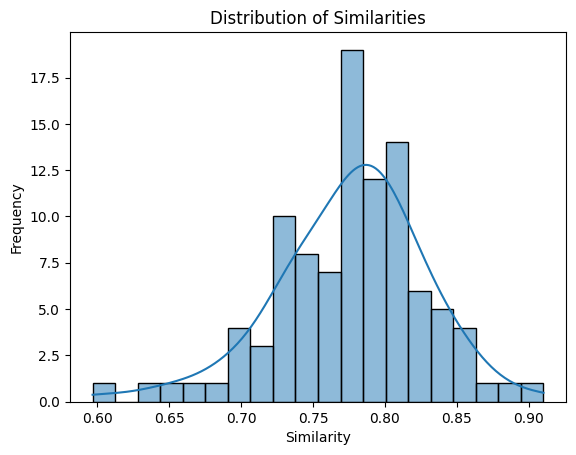

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plot the distribution of similarities
sns.histplot(df1_genAI['similarity'], bins=20, kde=True)

# Add titles and labels
plt.title('Distribution of Similarities')
plt.xlabel('Similarity')
plt.ylabel('Frequency')

# Show the plot
plt.show()


## **2.4 Search Engine Implementation**


In [ ]:
#### Added vector search capabilities

In [ ]:
#reseting the index as the original dataframe has been filtered for only selected products
df1_genAI = df1_genAI.reset_index(drop=True)

### 2.4.1 Building a Search Engine

We setup a nearest neighbor search using the **ScaNN (Scalar Quantized Approximate Nearest Neighbor)** library from **Google Research**.

ScaNN is a **library for efficient vector similarity search** and clustering on CPU.

Below is a breakdown of the code we'll use for the Search Engine:

- It retrieves the count of records from a Pandas DataFrame df1_genAI and stores it in the record_count variable.
- The embeddings from the embeddings_description column of the DataFrame are converted into a NumPy array dataset.
- The dataset is normalized using L2 normalization.

The ScaNN searcher has the following settings:

- It uses the "dot_product" distance measure.
- It builds a tree data structure with the number of leaves equal to the record_count, and searches all leaves.
- It uses a training sample size equal to the record_count.
- It applies the asymmetric hashing (AH) technique with a score of 2 and an anisotropic quantization threshold of 0.2.
- It reorders the dataset for better performance.



**Search Function:**

We define a search function, which takes a **query string as input** and **performs the nearest neighbor search**.

- It measures the start time.
- It gets the embedding for the query string using the embedding_model.
- It calls the `searcher.search` method to find the **top 3 nearest neighbors** and **their distances**.
- It prints the **document ID**, **distance**, and the **product name** for each neighbor.
- It calculates and prints the **search latency in milliseconds**.

In [ ]:
import scann
import numpy as np

record_count = df1_genAI["embeddings_description"].count()


dataset = np.array([df1_genAI.embeddings_description[i] for i in range(record_count)])


normalized_dataset = dataset / np.linalg.norm(dataset, axis=1)[:, np.newaxis]
# configure ScaNN as a tree - asymmetric hash hybrid with reordering
# anisotropic quantization as described in the paper; see README

# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
searcher = (
    scann.scann_ops_pybind.builder(normalized_dataset, 10, "dot_product")
    .tree(
        num_leaves=record_count,
        num_leaves_to_search=record_count,
        training_sample_size=record_count,
    )
    .score_ah(2, anisotropic_quantization_threshold=0.2)
    .reorder(100)
    .build()
)

def search(query: str) -> None:
    start = time.time()
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = searcher.search(query, final_num_neighbors=3)
    end = time.time()

    for id, dist in zip(neighbors, distances):
        print(f"[docid:{id}] [{dist}] -- {df1_genAI.nombre_producto[int(id)][:125]}...")

    print("Latency (ms):", 1000 * (end - start))


### 2.4.2 Testing the Search Engine:

Below we'll be testing the function to see how it works. We'll pass different queries and retrieve the Top 3 Products.



In [ ]:
search('tienes productos organicos?')

[docid:37] [0.6844835877418518] -- EL JUGO DE ARÁNDANO ORGÁNICO 100%...
[docid:24] [0.6790114045143127] -- 100% JUGO VARIEDAD ORGÁNICA...
[docid:65] [0.6720981597900391] -- EL JUGO DE ZANAHORIA ORGÁNICOS...
Latency (ms): 191.7586326599121


As we can observe, the search was succesful a provided a list of organic products.

In [ ]:
search('what natural drinks can you recommend?')

[docid:38] [0.7172486782073975] -- WILD CHERRY BEBIDA...
[docid:0] [0.7151784896850586] -- PURA AGUA DE COCO CON NARANJA...
[docid:63] [0.7079212665557861] -- JUGO ORGÁNICA BAJA EN SODIO DE SUPER VEGGIE...
Latency (ms): 80.42216300964355


**Another benefit** of this solution is that it understands queries in **different languages**.

This is important to highlight as Spain has a large community of expats and tourists that would find this feature helpful.

If in the future, Supercenter plans to expand to other countries or setup a multilingual store, the proposed solution is still valid.

**More examples:**

Below are a few examples that show that the search engine can also associate adjectives to a product making it a robust feature that will **enhance the customer online experience.**



In [ ]:
search('que bebida refrescante recomiendas?')

[docid:34] [0.8106683492660522] -- SIDRA Y JUGO DE ESPECIAS...
[docid:1] [0.7981777787208557] -- GRANADA ARÁNDANO Y ALOE VERA ENRICH BEBIDA...
[docid:35] [0.7840304374694824] -- COCO REAL BEBIDA DE ALOE VERA...
Latency (ms): 83.86683464050293


In [ ]:
search('refreshing beverage')

[docid:34] [0.7360032200813293] -- SIDRA Y JUGO DE ESPECIAS...
[docid:10] [0.7337429523468018] -- ORGÁNICA PONCHE DE FRUTAS...
[docid:32] [0.7297853231430054] -- ROARIN AGUAS BERRY BEBIDA CON SABOR A AGUA...
Latency (ms): 94.29526329040527


In [ ]:
search('agua saborizada')

[docid:32] [0.7707661986351013] -- ROARIN AGUAS BERRY BEBIDA CON SABOR A AGUA...
[docid:28] [0.7499832510948181] -- GIRO DE FRESA BEBIDA DEL JUGO...
[docid:64] [0.7465299367904663] -- EL AGUA DE COCO, ORGÁNICO PURO...
Latency (ms): 79.15496826171875


In [ ]:
search('orange juice')

[docid:50] [0.7177517414093018] -- JUGO DE CÓCTEL, ARÁNDANO BLOOD ORANGE...
[docid:69] [0.7033469676971436] -- JUGO ORGÁNICO DEL ARÁNDANO PURO...
[docid:64] [0.7030782699584961] -- EL AGUA DE COCO, ORGÁNICO PURO...
Latency (ms): 93.0168628692627


# **3. Solution #2:** Similar Products

### **Business Problem:**
SuperCenter's online store currently lacks a robust and personalized product recommendation system. Customers often struggle to discover relevant and interesting products beyond their initial search or purchase, leading to missed opportunities for additional sales and customer engagement.

The existing recommendation approach, which primarily relies on basic techniques such as recently viewed items or popular products, fails to provide tailored and contextualized recommendations that align with each customer's unique interests and preferences.


### **Use Case:** Personalized Product Recommendations

Implement an **embedding-based similarity search system** that **compares the vector representations (embeddings) of products to provide personalized recommendations** (**'Similar Products'**) to customers based on a **specific target product**.

**Enhance the online shopping experience** across all product categories by **offering relevant and engaging product recommendations** tailored to each customer's interests and preferences.

Increased customer engagement and satisfaction, measured through metrics like time spent on the website, number of pages visited, and customer satisfaction surveys.

Higher conversion rates and average order value, as customers are more likely to find and purchase additional relevant products they are interested in.

Better customer retention and loyalty, as personalized recommendations create a more tailored and enjoyable shopping experience.

Measure the impact through metrics such as click-through rates (CTR) on recommended products, conversion rates from recommendations, average order value for orders containing recommended products, and customer retention rates.


As we have already created the product descriptions and embeddings, **we build on top of our previous work to offer a complementary solution**.

An **embedding-based similarity search system will compute the similarity between a given product and all other products in a vector database**.

It will return a **sorted list of the most similar items**.

These results will be displayed in the product page under a title **'Similar Products'** so that shoppers can explore alternative and similar products to the ones they are browsing.

With this solution we **expect to increase the number of items per cart** as customers will be presented with more products of interest.



In [ ]:
from scipy.spatial.distance import cosine

# The product you want to find similar items for
target_product = 'PURA AGUA DE COCO CON NARANJA'

# Get the embedding for the target product
target_embedding = df1_genAI.loc[df1_genAI['nombre_producto'] == target_product, 'embeddings_description'].values[0]

# Calculate the cosine distance between the target embedding and all other embeddings
distances = df1_genAI['embeddings_description'].apply(lambda x: cosine(target_embedding, x))

# Sort the distances and get the indices of the most similar items
most_similar_indices = distances.sort_values().index

# Print the most similar products and their distances
print(f"Similar products for {target_product}:")
for idx in most_similar_indices[:5]:  # Top 5 most similar products
    product_name = df1_genAI.loc[idx, 'nombre_producto']
    product_distance = distances[idx]
    print(f"{product_name} (Distance: {product_distance:.4f})")

Similar products for PURA AGUA DE COCO CON NARANJA:
PURA AGUA DE COCO CON NARANJA (Distance: 0.0000)
100% NATURAL AGUA DE COCO (Distance: 0.0595)
PURA AGUA DE COCO CON FRUTAS TROPICALES (Distance: 0.0741)
PURA AGUA DE COCO (Distance: 0.0801)
EL AGUA DE COCO, ORGÁNICO PURO (Distance: 0.0853)


In [ ]:
# Second example
target_product_2 = 'FRUITWATER® FRESA KIWI AGUA CON GAS'

# Get the embedding for the second target product
target_embedding_2 = df1_genAI.loc[df1_genAI['nombre_producto'] == target_product_2, 'embeddings_description'].values[0]

# Calculate the cosine distance between the second target embedding and all other embeddings
distances_2 = df1_genAI['embeddings_description'].apply(lambda x: cosine(target_embedding_2, x))

# Sort the distances and get the indices of the most similar items
most_similar_indices_2 = distances_2.sort_values().index

# Print the most similar products and their distances
print(f"Similar products to {target_product_2}:")
for idx in most_similar_indices_2[:5]:  # Top 5 most similar products
    product_name = df1_genAI.loc[idx, 'nombre_producto']
    product_distance = distances_2[idx]
    print(f"{product_name} (Distance: {product_distance:.4f})")

Similar products to FRUITWATER® FRESA KIWI AGUA CON GAS:
FRUITWATER® FRESA KIWI AGUA CON GAS (Distance: 0.0000)
FRUITWATER ESPUMOSO LIMA LIMÓN (Distance: 0.0960)
GIRO DE FRESA BEBIDA DEL JUGO (Distance: 0.1312)
V FUSIÓN BERRY PARA FRUTAS Y VERDURAS BEBIDAS (Distance: 0.1437)
ROARIN AGUAS WILD CHERRY BEBIDAS AGUA (Distance: 0.1464)
